# 프로젝트: 주식 예측에 도전해 보자
- ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았습니다.
- 이제 실제 주식값 예측에 도전해 봅시다. 데이터는 과거의 일자별 시세입니다.
- 우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해 봅시다.

## STEP 1. 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams

# Time Series 생성

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2. 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [2]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [3]:
# 로그 변환
ts_log = np.log(ts)

## 필요 함수 Copy

In [4]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [5]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


## STEP 3. 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

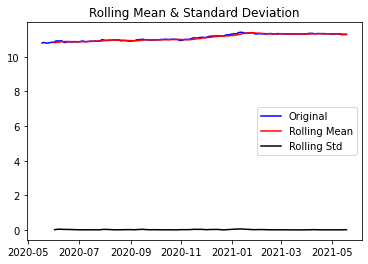

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


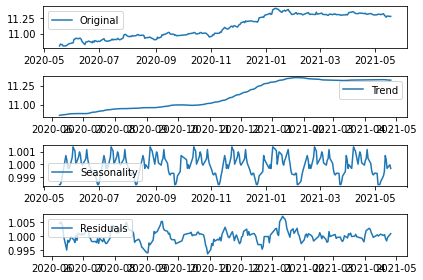

In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4. 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

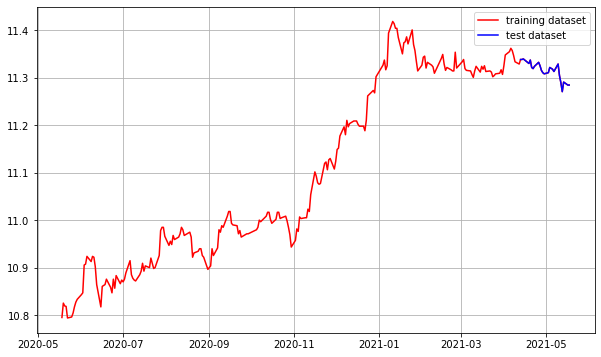

In [8]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5. 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

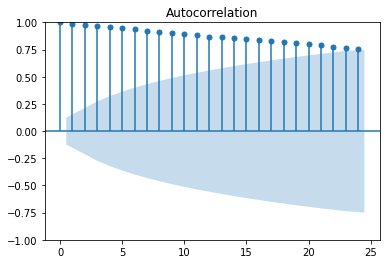

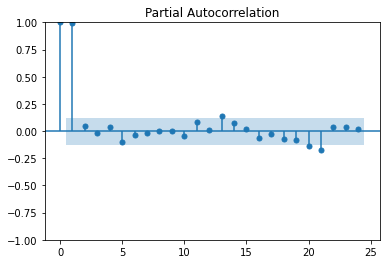

In [9]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


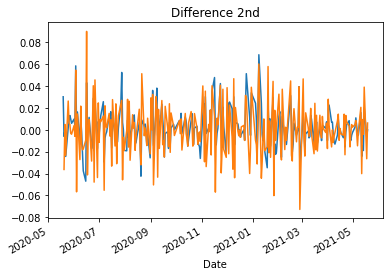

In [10]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6. ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [11]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Tue, 15 Feb 2022   AIC                          -1156.722
Time:                        05:19:33   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


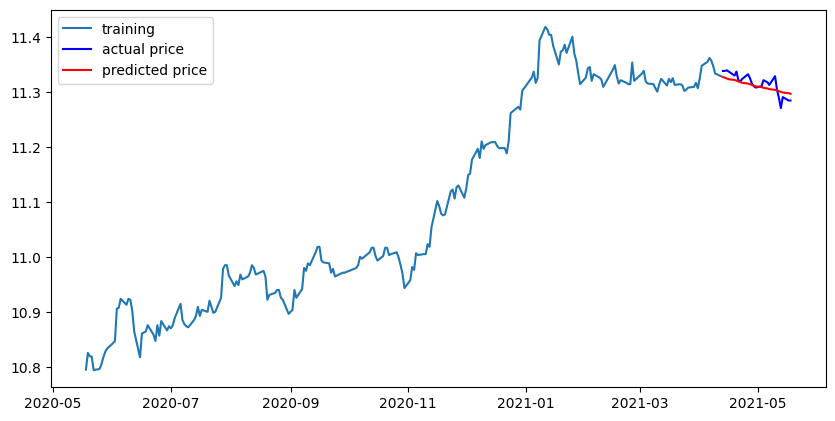

In [12]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


## STEP 7 (1). 다른 주식 종목 예측해 보기: Apple Inc.
- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

### 1. 시계열 데이터 준비

In [14]:
# Time Series 생성

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv' #Apple Inc.
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-16    133.190002
2021-02-17    130.839996
2021-02-18    129.710007
2021-02-19    129.869995
2021-02-22    126.000000
Name: Close, dtype: float64

### 2. 각종 전처리 수행
- 결측치 처리, 로그 변환

In [15]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
# 로그 변환
ts_log = np.log(ts)

### 3. 시계열 안정성 분석¶
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

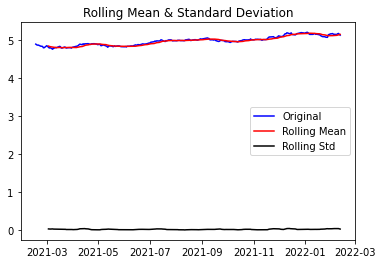

Results of Dickey-Fuller Test:
Test Statistic                  -0.749423
p-value                          0.833529
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


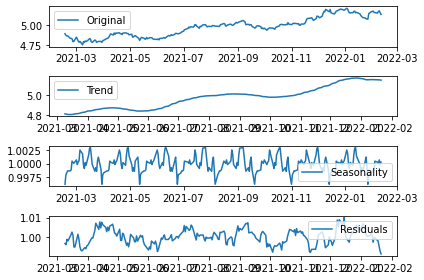

In [16]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [17]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.853624
p-value                          0.000043
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


- p=0.000043이므로 충분히 안정적이라고 볼 수 있음

### 4. 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

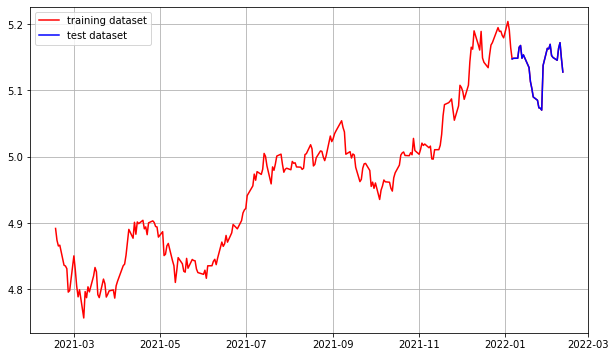

In [18]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5. 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

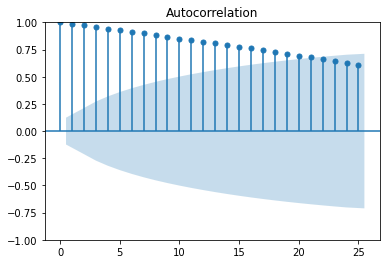

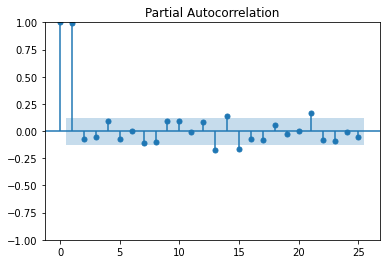

In [19]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF: 점차적으로 감소. 적합한 q값이 없어 보임 
- PACF: Time lag 1에서 1.0을 보이고 이후에 급격히 감소. 따라서 p=1이 적당하다고 추측할 수 있음
- (일반적으로, 일반적으로 p + q < 2, p * q = 0 인 값을 사용한다고 함... 교재)
<br> <br>
- p=1, q=0 이 적당하다고 추측할 수 있음 

Results of Dickey-Fuller Test:
Test Statistic                -1.598219e+01
p-value                        6.815993e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


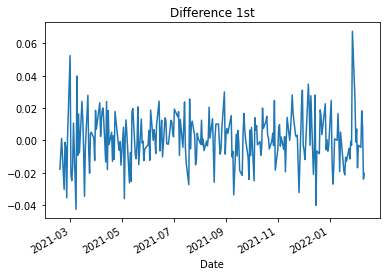

In [20]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
#diff_2 = diff_1.diff(periods=1).iloc[1:]
#diff_2.plot(title='Difference 2nd')

#augmented_dickey_fuller_test(diff_2)

- 1차 차분: p-value = 6.815993e-29이므로 안정화 상태를 보임. d=1이 적당하다고 추측할 수 있음

### 6. ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [21]:
# Build Model
#model = ARIMA(train_data, order=(0, 1, 1))  # order = (p, d, q)
#model = ARIMA(train_data, order=(14, 1, 0))  # order = (p, d, q)
#model = ARIMA(train_data, order=(60, 1, 0))  # order = (p, d, q)
#model = ARIMA(train_data, order=(45, 1, 0))  # order = (p, d, q)
#model = ARIMA(train_data, order=(40, 1, 0))  # order = (p, d, q)
#model = ARIMA(train_data, order=(35, 1, 0))  # order = (p, d, q)
#model = ARIMA(train_data, order=(33, 1, 0))  # order = (p, d, q)
#model = ARIMA(train_data, order=(34, 1, 0))  # order = (p, d, q)
#model = ARIMA(train_data, order=(38, 1, 0))  # order = (p, d, q)
#model = ARIMA(train_data, order=(36, 1, 0))  # order = (p, d, q)
model = ARIMA(train_data, order=(37, 1, 0))  # order = (p, d, q)

fitted_m = model.fit()

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                ARIMA(37, 1, 0)   Log Likelihood                 643.066
Date:                Tue, 15 Feb 2022   AIC                          -1210.131
Time:                        05:19:58   BIC                          -1080.319
Sample:                             0   HQIC                         -1157.738
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0731      0.077     -0.945      0.345      -0.225       0.079
ar.L2         -0.0132      0.077     -0.172      0.863      -0.164       0.137
ar.L3         -0.0286      0.078     -0.365      0.7

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


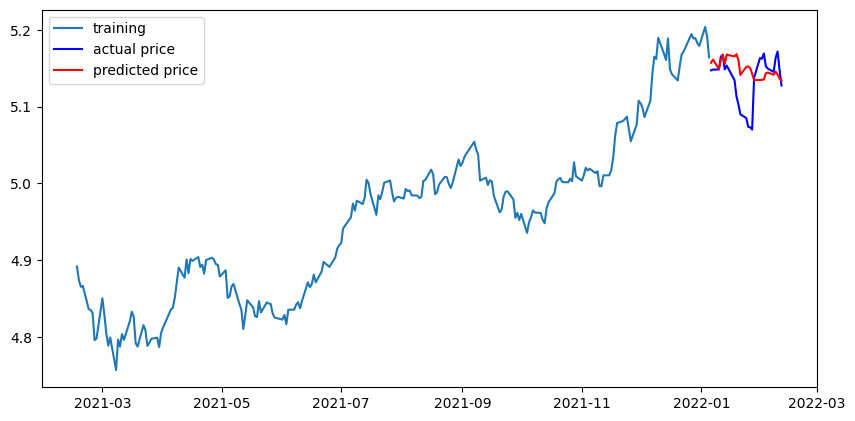

In [22]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [23]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  39.739319809333146
MAE:  4.666469220868483
RMSE:  6.303913055343732
MAPE: 2.81%


- (p, d, q) = (0, 1, 1)인 경우, MAPE: 3.31%
- (p, d, q) = (0, 1, 0)인 경우, MAPE: 3.14%
- (p, d, q) = (14, 1, 0)인 경우, MAPE: 3.53%
- (p, d, q) = (30, 1, 0)인 경우, MAPE: 3.11%
- (p, d, q) = (45, 1, 0)인 경우, MAPE: 2.99%
- (p, d, q) = (60, 1, 0)인 경우, MAPE: 3.15%
- (p, d, q) = (40, 1, 0)인 경우, MAPE: 2.95%
- (p, d, q) = (38, 1, 0)인 경우, MAPE: 2.84%
- (p, d, q) = (37, 1, 0)인 경우, MAPE: 2.81%
- (p, d, q) = (36, 1, 0)인 경우, MAPE: 3.01%
- (p, d, q) = (35, 1, 0)인 경우, MAPE: 2.85%
- (p, d, q) = (34, 1, 0)인 경우, MAPE: 2.90%
- (p, d, q) = (33, 1, 0)인 경우, MAPE: 3.28%
<br> <br>
- (p, d, q) = (37, 1, 0)인 경우, MAPE: 2.81% 최소값(?) 😉


## STEP 7 (2). 다른 주식 종목 예측해 보기: Lam Research
- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

### 1. 시계열 데이터 준비

In [24]:
# Time Series 생성

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/LRCX.csv' #Lam Research
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-16    591.789978
2021-02-17    585.909973
2021-02-18    577.770020
2021-02-19    598.409973
2021-02-22    567.799988
Name: Close, dtype: float64

### 2. 각종 전처리 수행

In [25]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
# 로그 변환
ts_log = np.log(ts)

### 3. 시계열 안정성 분석

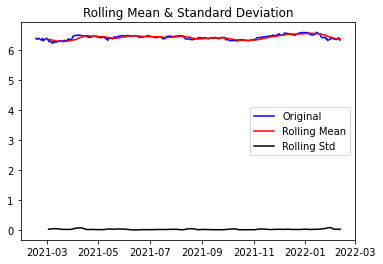

Results of Dickey-Fuller Test:
Test Statistic                  -2.798679
p-value                          0.058463
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


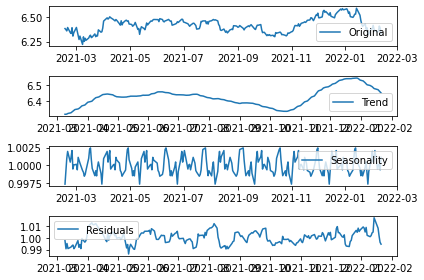

In [26]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [27]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.063729
p-value                          0.000017
#Lags Used                       2.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


- p=0.000017이므로 충분히 안정적이라고 볼 수 있음

### 4. 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

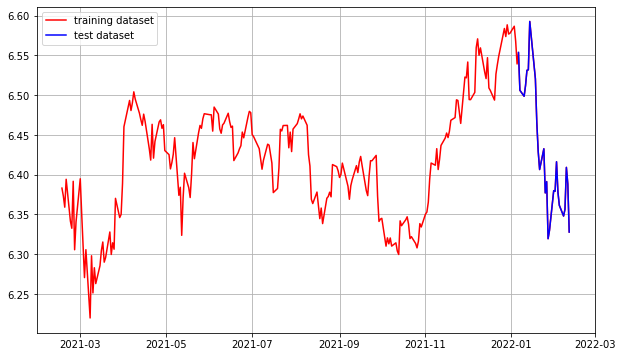

In [28]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5. 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

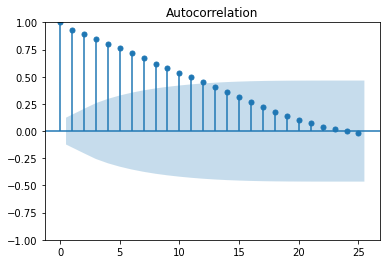

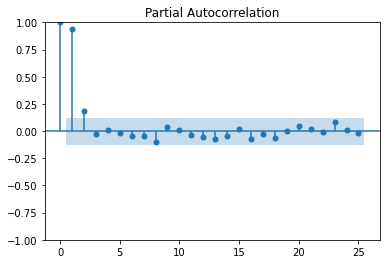

In [29]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF: Time lag 24를 기준으로 자기상관이 양에서 음으로 변동 
- PACF: Time lag 1에서 약 0.9를 보이고 이후에 급격히 감소. 따라서 p=1이 적당하다고 추측할 수 있음
- (일반적으로, 일반적으로 p + q < 2, p * q = 0 인 값을 사용한다고 함... 교재)
<br> <br>
- p=1, q=0 이 적당하다고 추측할 수 있음 

Results of Dickey-Fuller Test:
Test Statistic                 -18.891165
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


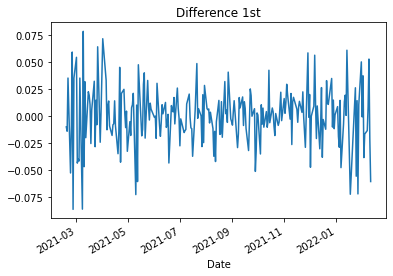

In [30]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- 1차 차분: p-value = 0.000000이므로 안정화 상태를 보임. d=1이 적당하다고 추측할 수 있음

### 6. ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [31]:
# Build Model
model = ARIMA(train_data, order=(30, 1, 0))  # order = (p, d, q)

fitted_m = model.fit()

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                ARIMA(30, 1, 0)   Log Likelihood                 521.143
Date:                Tue, 15 Feb 2022   AIC                           -980.286
Time:                        05:20:14   BIC                           -874.386
Sample:                             0   HQIC                          -937.544
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2175      0.066     -3.301      0.001      -0.347      -0.088
ar.L2         -0.0034      0.070     -0.048      0.961      -0.142       0.135
ar.L3         -0.0279      0.065     -0.426      0.6

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


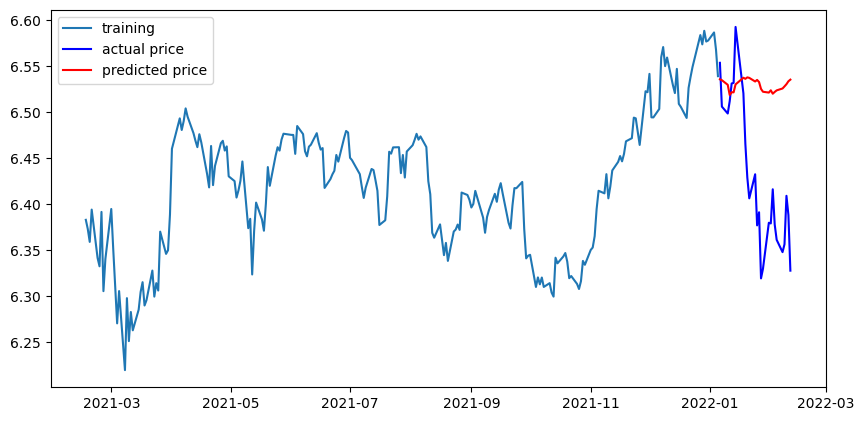

In [32]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [33]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  6380.14235582877
MAE:  69.03483440831516
RMSE:  79.87579330328288
MAPE: 11.64%


- (p, d, q) = (1, 1, 0)인 경우, MAPE: 13.04%
- (p, d, q) = (0, 1, 1)인 경우, MAPE: 13.20%
- (p, d, q) = (0, 1, 0)인 경우, MAPE: 12.54%
- (p, d, q) = (14, 1, 0)인 경우, MAPE: 12.62%
- (p, d, q) = (30, 1, 0)인 경우, MAPE: 11.64%
- (p, d, q) = (37, 1, 0)인 경우, MAPE: 12.38%
<br> <br>
- MAPE 15% 미만이므로 종료 😉

## STEP 7 (3). 다른 주식 종목 예측해 보기: Tesla, Inc.
- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

### 1. 시계열 데이터 준비

In [34]:
# Time Series 생성

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv' #Tesla, Inc.
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-16    796.219971
2021-02-17    798.150024
2021-02-18    787.380005
2021-02-19    781.299988
2021-02-22    714.500000
Name: Close, dtype: float64

### 2. 각종 전처리 수행

In [35]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
# 로그 변환
ts_log = np.log(ts)

### 3. 시계열 안정성 분석

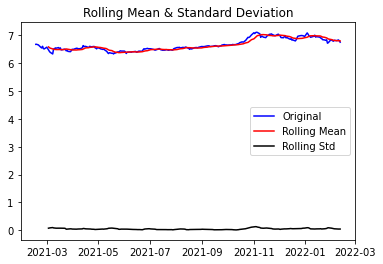

Results of Dickey-Fuller Test:
Test Statistic                  -1.323238
p-value                          0.618475
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


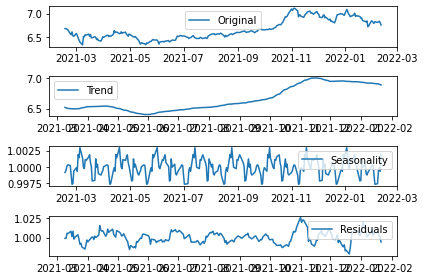

In [36]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [37]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.540508e+00
p-value                        9.372617e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64


- p=9.372617e-09이므로 충분히 안정적이라고 볼 수 있음

### 4. 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

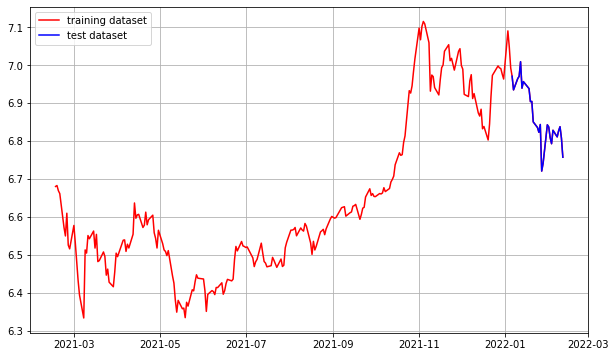

In [38]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5. 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

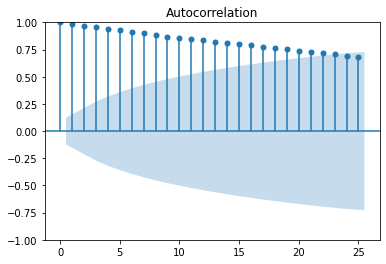

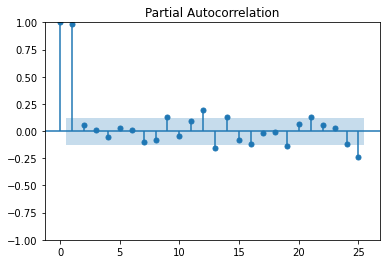

In [39]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF: 점차적으로 감소. 적합한 q값이 없어 보임 
- PACF: Time lag 1에서 1.0을 보이고 이후에 급격히 감소. 따라서 p=1이 적당하다고 추측할 수 있음
- (일반적으로, 일반적으로 p + q < 2, p * q = 0 인 값을 사용한다고 함... 교재)
<br> <br>
- p=1, q=0 이 적당하다고 추측할 수 있음 

Results of Dickey-Fuller Test:
Test Statistic                -1.671339e+01
p-value                        1.428356e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


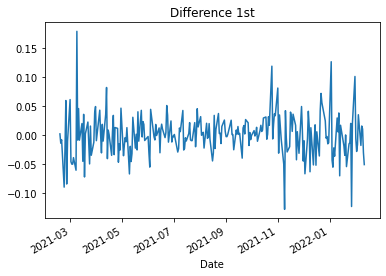

In [40]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- 1차 차분: p-value = 1.428356e-29이므로 안정화 상태를 보임. d=1이 적당하다고 추측할 수 있음

### 6. ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [41]:
# Build Model
model = ARIMA(train_data, order=(14, 1, 0))  # order = (p, d, q)
fitted_m = model.fit()

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                ARIMA(14, 1, 0)   Log Likelihood                 443.353
Date:                Tue, 15 Feb 2022   AIC                           -856.705
Time:                        05:20:20   BIC                           -805.464
Sample:                             0   HQIC                          -836.024
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0272      0.069     -0.394      0.694      -0.163       0.108
ar.L2          0.0103      0.060      0.173      0.863      -0.107       0.127
ar.L3          0.0273      0.072      0.377      0.7

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


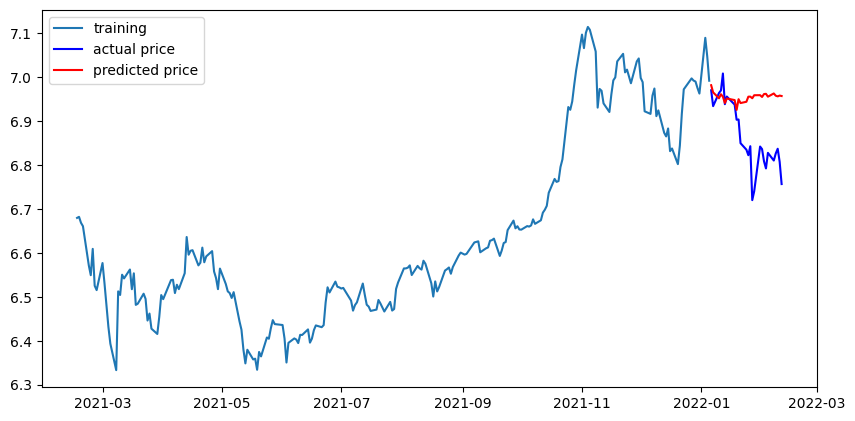

In [42]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [43]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  13483.469756470351
MAE:  95.57835277132767
RMSE:  116.11834375528422
MAPE: 10.52%


- (p, d, q) = (1, 1, 0)인 경우, MAPE: 14.52%
- (p, d, q) = (0, 1, 1)인 경우, MAPE: 14.56%
- (p, d, q) = (0, 1, 0)인 경우, MAPE: 14.21%
- (p, d, q) = (14, 1, 0)인 경우, MAPE: 10.52%
- (p, d, q) = (30, 1, 0)인 경우, MAPE: 14.18%
- (p, d, q) = (10, 1, 0)인 경우, MAPE: 13.78%
<br> <br>
- MAPE 15% 미만이므로 종료 😉

### 프로젝트 평가

| 평가문항 | 상세기준 | 실행 결과 |
|:---|:---|:---|
| 1. 시계열의 안정성이 충분히 확인되었는가? | 플로팅과 adfuller 메소드가 모두 적절히 사용되었음 | 사용했음 |
| 2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가? | p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨 | 제시하였음 |
| 3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가? | 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨 | Apple, Lam Research, Tesla 3개 사<br> 모두 15%미만 나옴 ||

### 회고
- 추가로 3개사에 대해 주가 예측 수행했음
- Time Series Forecasting과 그 중 ARIMA 모델에 대한 이해를 하였음
- 위의 모든 경우에 있어서 PACF 결과로 추측되는 p값은 모두 1이었으나, p=1일 때의 MAPE값이 최소값은 아니었음
- 주가 데이터는 장기적으로 보면 Stationary할 수도 있으나 단기적으로 그렇지 않으므로 시계열분석을 활용한 예측이 적절하다 하기는 어려움
- ARIMA모델과 같은 수학적 모델이 아닌, 인공지능 모델(generative 모델링이라고 함)이 초단기 Forecasting에 이용되고 있으며 정확도도 높다고 함
  - 몇 시간 후의 기상예측 등은 꽤 정확하다고 함
  - 인공지능 모델에 대한 공부가 필요하겠음

❓ 😉 🤗